<a href="https://colab.research.google.com/github/utkuyucel/Deep-Learning/blob/master/ResNet_TPU_Keras_CIFAR10_85_ACC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from keras.utils import to_categorical, plot_model
import numpy as np
import os

(X_train, y_train),(X_test, y_test) = tf.keras.datasets.cifar10.load_data()

Using TensorFlow backend.


In [2]:
try:
  device_name = os.environ['COLAB_TPU_ADDR']
  TPU_ADDRESS = 'grpc://' + device_name
  print('Found TPU at: {}'.format(TPU_ADDRESS))

except KeyError:
  print('TPU not found')

Found TPU at: grpc://10.79.250.34:8470


In [0]:
X_train = X_train.astype("float32")
X_test = X_test.astype("float32")

X_train /= 255
X_test /= 255

y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

In [0]:
def train_input_fn(batch_size=1024):
  # Girişleri bir veri kümesine dönüştür. 
  dataset = tf.data.Dataset.from_tensor_slices((X_train,y_train))

  # Karıştır, tekrar et ve batch (küme) örnekleri 
  dataset = dataset.shuffle(1000).repeat().batch(batch_size, drop_remainder=True)

  # veri kümesine.
  return dataset

In [0]:
def test_input_fn(batch_size=1024):
  # Girişleri bir veri kümesine dönüştür. .
  dataset = tf.data.Dataset.from_tensor_slices((X_test,y_test))

  # Karıştır, tekrar et ve batch (küme) örnekleri 
  dataset = dataset.shuffle(1000).repeat().batch(batch_size, drop_remainder=True)

  # veri kümesine.
  return dataset

In [0]:
def short(X_input, F1, F2, F3):
  
  X = tf.keras.layers.Conv2D(F1, (3,3), strides = (1,1), padding = "same")(X_input)
  X = tf.keras.layers.BatchNormalization()(X)
  X = tf.keras.layers.Activation("relu")(X)
  
  X = tf.keras.layers.Conv2D(F2, (3,3), strides = (1,1), padding = "same")(X)
  X = tf.keras.layers.BatchNormalization()(X)
  X = tf.keras.layers.Activation("relu")(X)

  X = tf.keras.layers.Conv2D(F3, (3,3), strides = (1,1), padding = "same")(X)
  X = tf.keras.layers.BatchNormalization()(X)
  
  L = tf.keras.layers.concatenate([X,X_input])
  
  L = tf.keras.layers.Activation("relu")(L)
  
  L = tf.keras.layers.MaxPooling2D((2,2))(L)
  
  return L

In [0]:
def model(X_input):
  
  X_input = tf.keras.layers.Input(X_input)
  
  X = tf.keras.layers.ZeroPadding2D((3,3))(X_input)
  
  X = short(X, 64, 64, 128)
  X = short(X, 64, 128, 256)
  X = short(X, 256, 512, 1024)
  
  FC = tf.keras.layers.AveragePooling2D(2,2)(X)
  
  F = tf.keras.layers.Flatten()(FC)
  
  FC = tf.keras.layers.Dense(10, activation = "softmax")(F)
  
  
  model = tf.keras.models.Model(inputs = X_input, outputs = FC)
  
  return model

In [0]:
model = model((32,32,3))

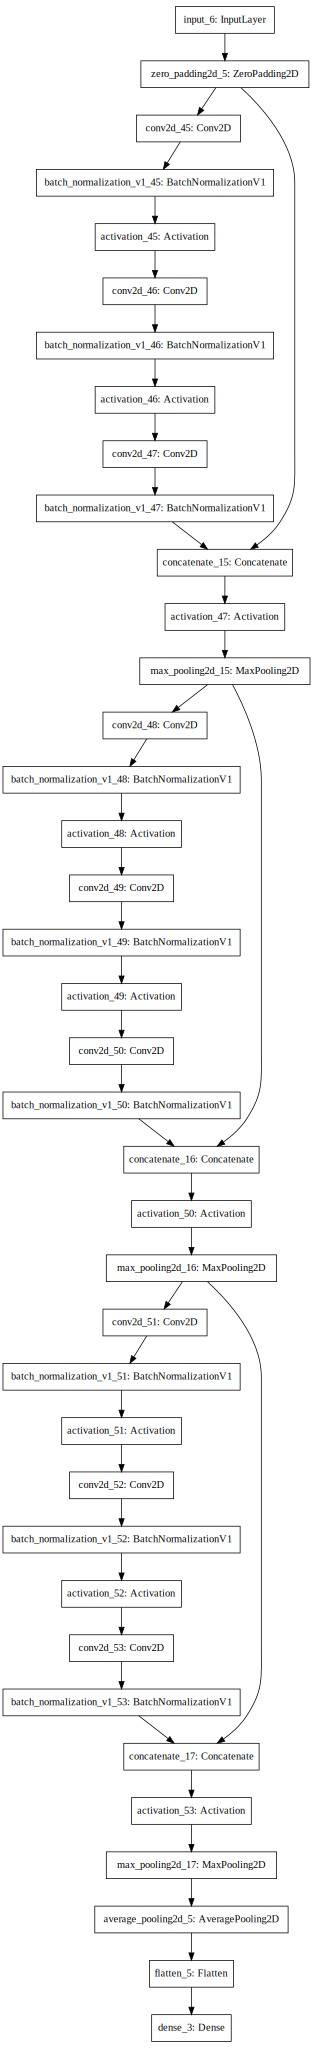

In [20]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

plot_model(model, to_file='model.png')
SVG(model_to_dot(model).create(prog='dot', format='svg'))


In [0]:
model.compile(optimizer = tf.train.AdamOptimizer(learning_rate = 0.001),
             loss = "categorical_crossentropy",
             metrics = ["acc"])

In [22]:
tpu_model = tf.contrib.tpu.keras_to_tpu_model(
    model,
    strategy=tf.contrib.tpu.TPUDistributionStrategy(
        tf.contrib.cluster_resolver.TPUClusterResolver(TPU_ADDRESS)))


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

INFO:tensorflow:Querying Tensorflow master (grpc://10.79.250.34:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 1658895426460709390)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 11986114461047884434)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 14983155888283923682)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:

In [23]:
tpu_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
zero_padding2d_5 (ZeroPadding2D (None, 38, 38, 3)    0           input_6[0][0]                    
__________________________________________________________________________________________________
conv2d_45 (Conv2D)              (None, 38, 38, 64)   1792        zero_padding2d_5[0][0]           
__________________________________________________________________________________________________
batch_normalization_v1_45 (Batc (None, 38, 38, 64)   256         conv2d_45[0][0]                  
__________________________________________________________________________________________________
activation

In [0]:
#tpu_model.load_weights("MNIST_TPU_1024.h5")

In [25]:
 tpu_model.fit(
  train_input_fn,
  steps_per_epoch = 60,
  epochs=20,
)

Epoch 1/20
INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(1024,), dtype=tf.int32, name=None), TensorSpec(shape=(1024, 32, 32, 3), dtype=tf.float32, name=None), TensorSpec(shape=(1024, 10), dtype=tf.float32, name=None)]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_6
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 23.813337326049805 secs
INFO:tensorflow:Setting weights on TPU model.
60/60 [==============================] - 70s 1s/step - loss: 2.4118 - acc: 0.3069
Epoch 2/20
60/60 [==============================] - 37s 611ms/step - loss: 1.2333 - acc: 0.5529
Epoch 3/20
60/60 [==============================] - 37s 609ms/step - loss: 0.7925 - acc: 0.7206
Epoch 4/20
60/60 [==============================] - 37s 610ms/step - loss: 0.5047 - acc: 0.8228
Epoch 5/20
60/

In [26]:
tpu_model.save_weights('./MNIST_TPU_1024.h5', overwrite=True)


INFO:tensorflow:Copying TPU weights to the CPU


In [27]:
tpu_model.evaluate(test_input_fn, steps = 100)

INFO:tensorflow:New input shapes; (re-)compiling: mode=eval (# of cores 8), [TensorSpec(shape=(1024,), dtype=tf.int32, name=None), TensorSpec(shape=(1024, 32, 32, 3), dtype=tf.float32, name=None), TensorSpec(shape=(1024, 10), dtype=tf.float32, name=None)]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_6
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 15.465731859207153 secs
100/100 [==============================] - 43s 427ms/step - loss: 0.7881 - acc: 0.8495


[0.7880574685335159, 0.8495288]